# Import libraries

In [28]:
import itertools
import math
import matplotlib.pyplot as plt
import numpy as np
from sage import MarginalImputer, PermutationEstimator

from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state

# Generate a gaussian linear model for a given design of causal probabilistic graph

In [29]:
def generate_causal_gaussian_lm(
    n_sample=1000,
    b=np.zeros(10),
    v=np.ones(10),
    w=np.vstack([np.zeros((9, 10)), np.ones((1, 10))]),
    random_state=None,
):
    """
    Generate samples distributed according to a Directed Acyclic Graph over D variables `X = (x_i)_{i=1, ..., D}` and a target `Y`.
    We assume the variables are numbered so that if `j \\in pa_i` then `j<i`.
    The conditional of `x_i` conditioned on its parents `pa_i` is `p(x_i|pa_i) = \\mathcal{N}(x_i | \\sum_{j \\in pa_i w_{i,j}x_j + b_i , v_i})`

    Parameters
    ----------
    n_samples : int 
        The number of samples to draw.
    n_features : int
        The number of features in the model.
    b : ndarray of shape (n_features + 1,)
        The bias terms.
    v : ndarray of shape (n_features + 1,)
        The variance terms.
    w : ndarray of shape (n_features + 1, n_features + 1)
        The weights representing the conditional relation between i and its parent j.
        Zero if i and j are marginally independant.
    random_state : int
        Seed of the random number generator.

    Returns
    ----------
    X : ndarray of shape (n_samples, n_features)
        The matrix of covariates of the model.
    Y : ndarray of shape (n_samples,)
        The target of the model.
    mu : ndarray of shape (n_features + 1,)
        The mean vector of the multivariate gaussian (X, Y).
    Sigma : ndarray of shape (n_features + 1, n_features + 1)
        The variance-covariance matrix of the multivariate gaussian (X, Y).
    Note
    ----------
    - The model (X, Y) follows a multivariate gaussian distribution whose mean and covariance matrix can be computed recursively
        in the following manner (Bishop, section 8.1.4):
        - `\\mu_i = \\sum_{j \\in pa_i} w_{i,j} \\mu_j + b_i`
        - `\\Sigma_{i,j} = \\sum_{k \\in pa_j} w_{j,k} \\Sigma_{i,k} + I_{i=j}v_i`
    - The default is a model where covariates are sampled from independant standard distributions, and the output from a normal distribution
        centered on the sum of covariates with variance 1.
    """
    rng = check_random_state(random_state)
    D = b.shape[0] - 1
    mu = np.zeros(D + 1)
    Sigma = np.zeros((D + 1, D + 1))

    for i in range(D + 1):
        mu[i] = w[i, :] @ mu + b[i]

        for j in range(i, D + 1):
            Sigma[i, j] = w[j, :] @ Sigma[i, :] + (i == j) * v[i]
            Sigma[j, i] = Sigma[i, j]

    Xy = rng.multivariate_normal(mu, Sigma, n_sample)
    X, y =  Xy[:, :-1], Xy[:, -1],
    return X, y, mu, Sigma


# Compute the exact SAGE values for this model

In [30]:
def expected_conditional_variance_reduction(S, i, Sigma):
    """
    Computes the expected variance reduction in the conditional expectation of Y
    when adding feature X_i to a conditioning set X_S, under the assumption that
    we generated the model with generate_causal_gaussian_lm()

    The quantity computed is:
        `E[Var(E[Y | X_S, X_i] | X_S)] = E[Var(Y | X_S)] - E[Var(Y | X_S, X_i)]`

    Since we know the covariance matrix of (X,Y), by property of multivariate gaussian random variables, this simplifies as:
        `(Sigma_yy - Sigma_yS Sigma_SS^-1 Sigma_Sy) - (Sigma_yy - Sigma_yA Sigma_AA^-1 Sigma_Ay)`
        `= Sigma_yA Sigma_AA^-1 Sigma_Ay - Sigma_yS Sigma_SS^-1 Sigma_Sy `
    when we let `A := S \\cup {i}`

    Parameters
    ----------
    S : list or array of int
        indices of features in the conditioning set X_S
    i : int
        index of the feature X_i to evaluate (must not be in S)
    Sigma : ndarray of shape (n_features + 1, n_features + 1)
        The variance-covariance matrix of the multivariate gaussian (X, Y).
    
    Returns
    ----------
    out : float
        the expected conditional variance reduction
    """
    S = list(S)
    if i in S:
        raise ValueError("Feature index i should not be in S")

    A = S + [i]

    # Extract relevant submatrices from Sigma
    Sigma_SS = Sigma[np.ix_(S, S)]
    Sigma_yS = Sigma[-1, S]
    Sigma_Sy = Sigma_yS.T

    Sigma_AA = Sigma[np.ix_(A, A)]
    Sigma_yA = Sigma[-1, A]
    Sigma_Ay = Sigma_yA.T

    # Compute conditional covariances
    left_term = Sigma_yA @ np.linalg.solve(Sigma_AA, Sigma_Ay)
    right_term = Sigma_yS @ np.linalg.solve(Sigma_SS, Sigma_Sy)

    return left_term - right_term


In [31]:
def compute_bayes_sage(i, Sigma):
    """
    Computes the average marginal contribution of feature i for the Bayes model:

        `(1/d) * sum_{S \\subseteq D^{-i}} (1 / C(d-1, |S|)) * E[Var(E[Y | X_S, X_i] | X_S)]`

    where:
    - `D = {0, 1, ..., d-1}` is the set of all feature indices
    - S runs over all subsets of `D^{-i}`
    - (X,Y) was generated with generate_causal_gaussian_lm()

    Parameters
    ----------
    i : int
        index of the feature of interest
    Sigma : ndarray of shape (n_features + 1, n_features + 1)
        The variance-covariance matrix of the multivariate gaussian (X, Y).

    Returns
    ----------
    - out : float
        SAGE value of feature i for the optimal model
    """
    d = Sigma.shape[0] - 1
    D_minus_i = [j for j in range(d) if j != i]
    total = 0.0

    for k in range(d):  # |S| = 0 to d-1
        subsets_of_size_k = list(itertools.combinations(D_minus_i, k))
        weight = 1 / math.comb(d - 1, k)
        for S in subsets_of_size_k:
            v = expected_conditional_variance_reduction(S, i, Sigma)
            total += weight * v

    return total / d


# Define the parameters of the training loop and the model

In [32]:
# We will first consider the following DAG (arrows are directed downwards):
#             x_0
#             / \
#       x_1 x_2 x_3
#         \  |  / \
#          \ | /  x_4
#            y
# Where the only non negative weights are w_2,0 ; w_3,0 ; w_4,3 ; w_y,1 ; w_y,2 ; w_y,3
# We choose arbitrary values for the weight, bias and variance terms and therefore define:

#             x0  x1 x2 x3 x4 y
b = np.array([1, -1, 0, 2, 1, 2])

#             x0   x1   x2   x3   x4   y
v = np.array([0.2, 0.2, 0.2, 0.2, 0.2, 0.2])

w = np.array([
#    x0   x1   x2   x3   x4   y
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], #x0
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], #x1
    [0.1, 0.0, 0.0, 0.0, 0.0, 0.0], #x2
    [0.1, 0.0, 0.0, 0.0, 0.0, 0.0], #x3
    [0.0, 0.0, 0.0, 0.1, 0.0, 0.0], #x4
    [0.0, 0.5, 0.5, 0.5, 0.0, 0.0], #y
])

n_feature = b.shape[0] - 1

In [33]:
# Training loop parameters
train_sizes = np.logspace(2, 5, 7, dtype=int)
test_size = train_sizes[-1]
n_folds = 5
rng = np.random.RandomState(42)
n_estimators = 100


# Training loop and feature importance measures

In [34]:
mdi_res = np.zeros((len(train_sizes), n_feature))
umdi_res = np.zeros((len(train_sizes), n_feature))
sage_res = list()
permut_res = list()
mse_improvement = np.zeros(len(train_sizes))

X, y, mu, Sigma = generate_causal_gaussian_lm(
    n_sample=train_sizes[-1] + test_size,
    b=b,
    v=v,
    w=w,
    random_state=rng,
)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, shuffle=True, random_state=rng
)

bayes_sage = [compute_bayes_sage(i, Sigma) for i in range(n_feature)]
for train_size_idx, train_size in enumerate(train_sizes):
    X_train_subsample, y_train_subsample, X_test_subsample, y_test_subsample = (
        X_train[:train_size],
        y_train[:train_size],
        X_test[:train_size],
        y_test[:train_size],
    )
    reg = RandomForestRegressor(
        n_estimators=n_estimators,
        oob_score=True,
        n_jobs=-1,
        random_state=rng,
    ).fit(X_train_subsample, y_train_subsample)

    mdi_res[train_size_idx, :] = reg._unnormalized_feature_importances
    umdi_res[train_size_idx, :] = reg.unbiased_feature_importances_

    imputer = MarginalImputer(reg, X_test_subsample[:500])
    estimator = PermutationEstimator(imputer, "mse", random_state=rng)
    sage_res.append(
        estimator(X_test_subsample, y_test_subsample, thresh=0.1, bar=False)
    )
    permut_res.append(
        permutation_importance(reg, X_test, y_test, n_repeats=5, random_state=rng)
    )

    dummy = DummyRegressor(strategy="mean").fit(X_train_subsample, y_train_subsample)

    mse_improvement[train_size_idx] = mean_squared_error(
        y_test_subsample, dummy.predict(X_test_subsample)
    ) - mean_squared_error(y_test_subsample, reg.predict(X_test_subsample))


In [35]:
mse_improvement

array([0.10240979, 0.13616081, 0.1385673 , 0.13304866, 0.14064146,
       0.1393598 , 0.13923568])

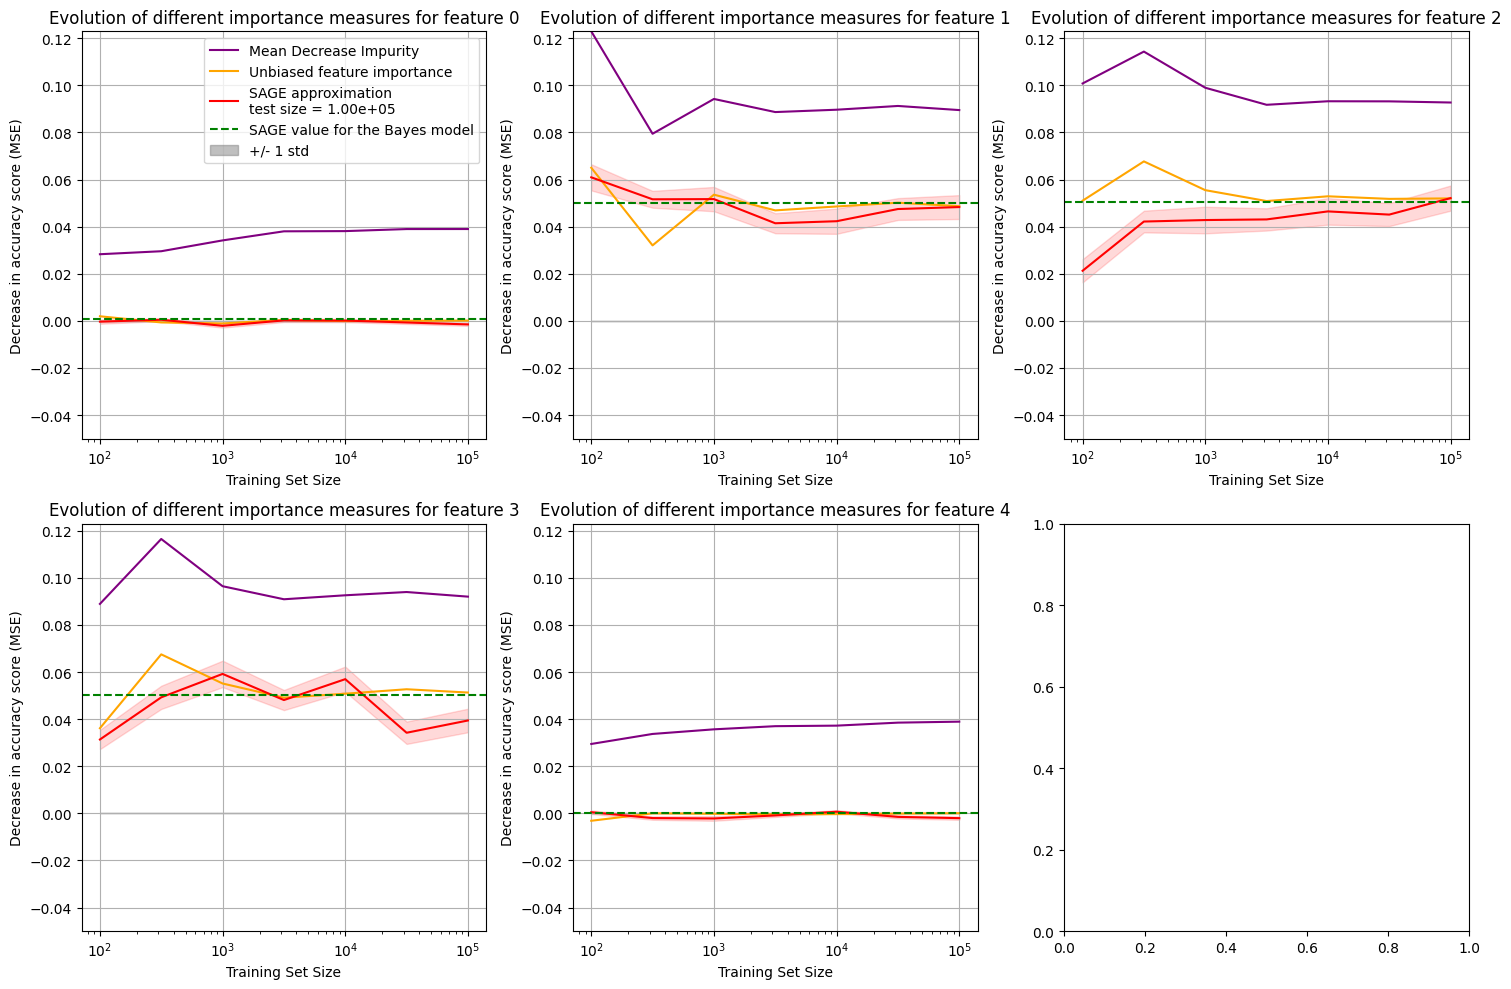

In [36]:
global_max = np.max(
    [
        mdi_res,
        umdi_res,
        [sage_res[j].values + sage_res[j].std for j in range(len(train_sizes))],
        # [
        #     permut_res[j].importances_mean + permut_res[j].importances_std
        #     for j in range(len(train_sizes))
        # ],
    ]
)

# Plot
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()

for i in range(n_feature):
    axs[i].set_ylim(-0.05, global_max)
    axs[i].plot(
        train_sizes, mdi_res[:, i], label="Mean Decrease Impurity", color="purple"
    )
    axs[i].plot(
        train_sizes, umdi_res[:, i], label="Unbiased feature importance", color="orange"
    )
    axs[i].plot(
        train_sizes,
        [sage_res[j].values[i] for j in range(len(train_sizes))],
        label=f"SAGE approximation \ntest size = {test_size:.2e}",
        color="red",
    )
    axs[i].fill_between(
        train_sizes,
        [sage_res[j].values[i] + sage_res[j].std[i] for j in range(len(train_sizes))],
        [sage_res[j].values[i] - sage_res[j].std[i] for j in range(len(train_sizes))],
        color="red",
        alpha=0.15,
    )
    # axs[i].plot(
    #     train_sizes,
    #     [permut_res[j].importances_mean[i] for j in range(len(train_sizes))],
    #     label=f"permutation importance \ntest size = {test_size:.2e}",
    #     color="cyan",
    # )
    # axs[i].fill_between(
    #     train_sizes,
    #     [
    #         permut_res[j].importances_mean[i] + permut_res[j].importances_std[i]
    #         for j in range(len(train_sizes))
    #     ],
    #     [
    #         permut_res[j].importances_mean[i] - permut_res[j].importances_std[i]
    #         for j in range(len(train_sizes))
    #     ],
    #     color="cyan",
    #     alpha=0.15,
    # )
    axs[i].axhline(bayes_sage[i], ls="--", label="SAGE value for the Bayes model", color="green")
    # axs[i].axhline(model_weights[i], ls="-.", label="Weight in the model", color="black")
    axs[i].fill_between(train_sizes, 0, 0, color="gray", alpha=0.5, label="+/- 1 std")
    axs[i].set_xscale("log")
    axs[i].set_xlabel("Training Set Size")
    axs[i].set_ylabel("Decrease in accuracy score (MSE)")
    axs[i].set_title(
        f"Evolution of different importance measures for feature {i}"
    )
    axs[i].grid(True)
axs[0].legend()

plt.tight_layout()
plt.show()
